In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [40]:
words = open("data/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [41]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [42]:
block_size = 3 # context length: how many chars de we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [43]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 5/3/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.02
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g)

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12297


In [44]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (32, 3, 2)
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 # want this to be roughly gaussian
  # batch norm layer
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # gaussian
  h = torch.tanh(hpreact) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.9577
  10000/ 200000: 2.2739
  20000/ 200000: 2.1343
  30000/ 200000: 2.3421
  40000/ 200000: 2.6160
  50000/ 200000: 2.1559
  60000/ 200000: 2.2107
  70000/ 200000: 2.1187
  80000/ 200000: 2.4302
  90000/ 200000: 2.1484
 100000/ 200000: 2.1660
 110000/ 200000: 1.9029
 120000/ 200000: 2.4969
 130000/ 200000: 2.3040
 140000/ 200000: 2.1810
 150000/ 200000: 1.9106
 160000/ 200000: 2.2765
 170000/ 200000: 2.2313
 180000/ 200000: 2.1533
 190000/ 200000: 2.1426


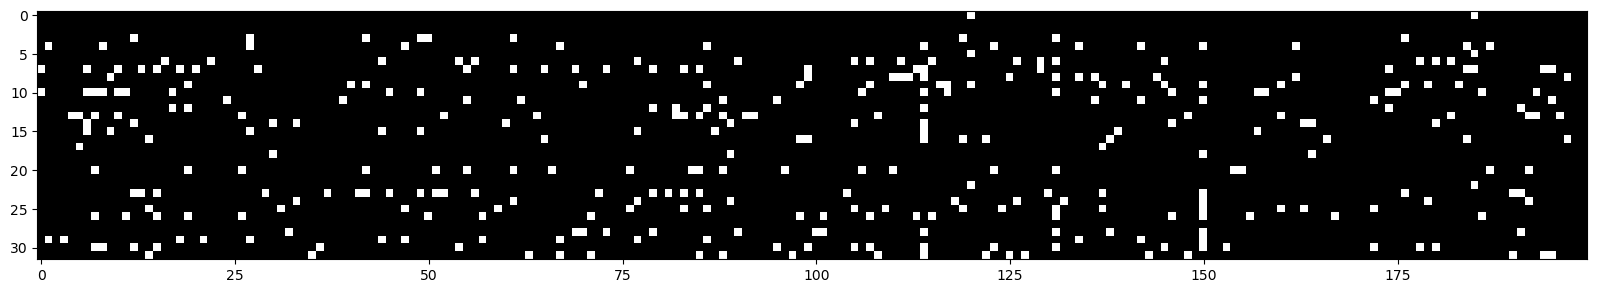

In [45]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest");
# going through neurons and checking firing
# whole white column would mean a dead neuron

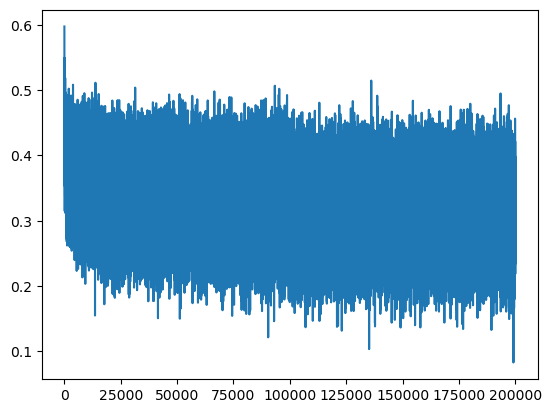

In [46]:
plt.plot(lossi);

In [50]:
# calibrate batch norm at the end of training
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [51]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    "train" : (Xtr, Ytr),
    "val": (Xdev, Ydev),
    "test": (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  h = torch.tanh(embcat @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss("train")
split_loss("val")

train 3.003465414047241
val 3.038245916366577


In [48]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print("".join(itos[i] for i in out))

chrizhxqteriqliff.
mrix.
thtydnn.
addn.
jazhnnn.
brthy.
til.
qtie.
ramsisschrigh.
khleggbbhlm.
trindquqtnishlyn.
trvinnquintth.
gvetryngtth.
evzdustimestepxia.
gths.
tys.
khal.
qimbvychssyah.
mabdgb.
stycolbniyaj.


In [13]:
# things to look out for
# 1. checking that the weights are correctly init'ed so that you don't have a "hocky stick" loss
# 2. 